In [ ]:
# Auther: Tzu-Han Hsu

# BSD 3-Clause License

# Copyright (c) 2022, Anywhere Door Lab (ADL) and Tzu-Han Hsu
# All rights reserved.

# Redistribution and use in source and binary forms, with or without
# modification, are permitted provided that the following conditions are met:

# 1. Redistributions of source code must retain the above copyright notice, this
#    list of conditions and the following disclaimer.

# 2. Redistributions in binary form must reproduce the above copyright notice,
#    this list of conditions and the following disclaimer in the documentation
#    and/or other materials provided with the distribution.

# 3. Neither the name of the copyright holder nor the names of its
#    contributors may be used to endorse or promote products derived from
#    this software without specific prior written permission.

# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
# AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
# IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
# DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
# FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
# DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
# SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
# CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
# OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
# OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

In [1]:
import torch
import torchvision 
import os
from torch.utils import data
from PIL import Image
import torchvision.datasets as dset
import numpy as np

import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from tqdm.notebook import tqdm
import torchvision.models as models
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import matplotlib.pyplot as plt
import pickle
from torchsummary import summary

#vital params

 
model_name="ResNet152"

dataset_name="tsrd"

#hyperparameters
batch_size=20
num_classes=-1
learning_rate=0.001
input_size=784
image_size=(224,224)


if dataset_name == "tsrd":
    num_classes=58
elif dataset_name == "cifar10":
    num_classes=10
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Model: "+model_name +" with {} classes".format(num_classes)+
      " running on: "+dataset_name)


Model: ResNet152 with 58 classes running on: tsrd


In [2]:
# load data through imagefolder
if dataset_name == "tsrd":
    main_transforms=transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406] , std = [0.229, 0.224, 0.225]),

    ])

    train_dir = "../../dataset/data"
    head_train_set = dset.ImageFolder(train_dir,transform=main_transforms)
    train_set, valid_set = data.random_split(head_train_set, [5000, 998])
    train_set, test_set = data.random_split(train_set,[4000, 1000])


    train_dataloader=torch.utils.data.DataLoader(train_set,
                                                 batch_size=batch_size,
                                                 shuffle=True)

    val_dataloader=torch.utils.data.DataLoader(valid_set,
                                                 batch_size=batch_size,
                                                 shuffle=True)

    test_dataloader=torch.utils.data.DataLoader(test_set,
                                                 batch_size=1,
                                                 shuffle=True)
elif dataset_name == "cifar10":
    
    main_transforms=transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.5, 0.5, 0.5] , std = [0.5, 0.5, 0.5]),

    ])

    bigtrain_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=main_transforms)
    train_set, valid_set = data.random_split(bigtrain_set, [40000, 10000])
    test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=main_transforms)


    train_dataloader = torch.utils.data.DataLoader(train_set, 
                                                   batch_size=batch_size, 
                                                   shuffle=True, num_workers=2)

    val_dataloader = torch.utils.data.DataLoader(valid_set, 
                                                   batch_size=batch_size, 
                                                   shuffle=True, num_workers=2)

    test_dataloader = torch.utils.data.DataLoader(test_set,
                                                  batch_size=batch_size,
                                                  shuffle=False, num_workers=2)




print("Dataset size: Train: {}, Valid: {}, Test: {}"
      .format(len(train_set),len(valid_set),len(test_set)))

print(head_train_set.class_to_idx)
print(train_set[0][0].shape)
print("Datasets loaded and prepared")

Dataset size: Train: 4000, Valid: 998, Test: 1000
{'0': 0, '1': 1, '10': 2, '11': 3, '12': 4, '13': 5, '14': 6, '15': 7, '16': 8, '17': 9, '18': 10, '19': 11, '2': 12, '20': 13, '21': 14, '22': 15, '23': 16, '24': 17, '25': 18, '26': 19, '27': 20, '28': 21, '29': 22, '3': 23, '30': 24, '31': 25, '32': 26, '33': 27, '34': 28, '35': 29, '36': 30, '37': 31, '38': 32, '39': 33, '4': 34, '40': 35, '41': 36, '42': 37, '43': 38, '44': 39, '45': 40, '46': 41, '47': 42, '48': 43, '49': 44, '5': 45, '50': 46, '51': 47, '52': 48, '53': 49, '54': 50, '55': 51, '56': 52, '57': 53, '6': 54, '7': 55, '8': 56, '9': 57}
torch.Size([3, 224, 224])
Datasets loaded and prepared


In [3]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1
 
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride
 
    def forward(self, x):
        residual = x
 
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
 
        out = self.conv2(out)
        out = self.bn2(out)
 
        if self.downsample is not None:
            residual = self.downsample(x)
 
        out += residual
        out = self.relu(out)
 
        return out
class Bottleneck(nn.Module):
    expansion = 4
 
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
 
    def forward(self, x):
        residual = x
 
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
 
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
 
        out = self.conv3(out)
        out = self.bn3(out)
 
        if self.downsample is not None:
            residual = self.downsample(x)
 
        out += residual
        out = self.relu(out)
 
        return out
class ResNet(nn.Module):
 
    def __init__(self, block, layers, num_classes=1000):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)
 
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
 
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )
 
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))
 
        return nn.Sequential(*layers)
 
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
 
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
 
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
 
        return x

def resnet18(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    return model
 
 
def resnet34(pretrained=False, **kwargs):
    """Constructs a ResNet-34 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet34']))
    return model
 
 
def resnet50(pretrained=False, **kwargs):
    """Constructs a ResNet-50 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet50']))
    return model
 
 
def resnet101(pretrained=False, **kwargs):
    """Constructs a ResNet-101 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 23, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet101']))
    return model
 
 
def resnet152(pretrained=False, **kwargs):
    """Constructs a ResNet-152 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 8, 36, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet152']))
    return model

In [5]:
model = resnet152()
model.fc=nn.Linear(2048,num_classes)
model = model.to(device)

from thop import profile
import colorama
from colorama import Fore,Style
def getGFLOPS(test_model):
    model=test_model.to(device)
    input = torch.randn(1, 3, 224, 224).to(device)
    macs, params = profile(model, inputs=(input, ))

    print(Fore.BLUE + "The model requires: {:.4f} GFLOPS".format(macs/1000_000_000))
    print(Style.RESET_ALL)
    return macs
getGFLOPS(model)

#pretesting model for shape
x=torch.randn(64,3,224,224)
x=x.to(device)
print(x.shape)
print(model(x).shape)
print("model shape ready")
print(summary(model, input_size=(3, 224, 224)))
#initailise network


#loss and optimizer
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=learning_rate)
print("model initialised")

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_bn() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Bottleneck'>. Treat it as zero Macs and zero Params.
[INFO] Register count_avgpool() for <class 'torch.nn.modules.pooling.AvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class '__main__.ResNet'>. Treat it as zero Macs and zero Params.
The model requires: 11.5568 GFLOPS

torch.Size([64, 3, 224, 224])
torch.Size([64, 58])
model shape ready
----------------------------------------------------------------
        Layer (type)               Output Shape        

In [ ]:
# This is the testing part
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp
get_n_params(model)

def test(model, test_loader, istest= False, doprint=True):
    model.eval()
    test_loss = 0
    correct = 0
    TP=0
    TN=0
    FN=0
    FP=0
    test_loss = 0.0
    
    with torch.no_grad(): # disable gradient calculation for efficiency
        for data, target in tqdm(test_loader):
            # Prediction
            data=data.to(device=device)
            target=target.to(device=device)
            optimizer.zero_grad()
            
            output = model(data)
            loss=criterion(output,target)
            
            # Compute loss & accuracy
            test_loss+=loss.item()*data.size(0)

            
            #test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item() # how many predictions in this batch are correct
            
            #print("pred={} , target={} , judge={}".format(pred.item(),target.item(),pred.eq(target.view_as(pred)).sum().item()))

            
    #test_loss /= len(test_loader.dataset)

        
    # Log testing info
    if istest and doprint:
        
        print('Loss: {}   Accuracy: {}/{} ({:.3f}%)'.format(test_loss,
        correct, len(test_loader.dataset),
        100.000 * correct / len(test_loader.dataset)))
        print("Total parameters: {}".format(get_n_params(model)))
    elif doprint:
        print('Accuracy: {}/{} ({:.3f}%)'.format(
        correct, len(test_loader.dataset),
        100.000 * correct / len(test_loader.dataset)))
    return 100.000 * correct / len(test_loader.dataset)
        

print("test defined")

def testshouldearlystop(acclist,minepoch,epochwindow,accwindow):
    runlen=len(acclist)
    if(runlen<minepoch):
        return False
    elif(acclist[-1]>acclist[-2]):
        return False
    
    watchwindow=acclist[-epochwindow:]
    shouldjump=True
    sum=0
    for i in watchwindow:
        sum+=i
    avg = sum/epochwindow
    for i in watchwindow:
        if abs(i-avg)>(accwindow):
            shouldjump=False
    return shouldjump
print("early stop defined")

In [7]:
now=datetime.now()
dt_string = now.strftime("%Y%m%d%H%M%S")

tensorboard_string="runs/"+"/"+model_name+dt_string
grandstore_string="grandstore/"+dataset_name+"_"+model_name+dt_string+".pkl"
print("tensorboard_string:")
print(tensorboard_string)
print("grandstore_string")
print(grandstore_string)


writer = SummaryWriter(tensorboard_string)


tensorboard_string:
runs//ResNet15220211023095142
grandstore_string
grandstore/tsrd_ResNet15220211023095142.pkl


In [8]:
#This is the training part

# Grand_store={
#     'total_epoch_run':-1
#     'topmodels':-1
#     'lastmodel':-1
#     'acclog':[]
#     'maxacc':-1
#     'minacc':101
# }
# train_epoch={
#     "numofepoch":-1
#     "accuracy":-1
#     "model_state":model.state_dict(),
#     "optim_state":optimizer.state_dict(),
#     "totaltrain_loss":totaltrain_loss,
#     "totalvalid_loss":totalvalid_loss
# }

def training(max_epoch=120, top_accuracy_track=3, grandstore={},
             minepoch=30,epochwindow=10,accwindow=0.35):

    grandstore['total_epoch_run']=0
    grandstore['topmodels']=[]
    grandstore['acclog']=[]
    grandstore['maxacc']=-1
    grandstore['minacc']=101
    
    for epoch in range(0,max_epoch):
        
        grandstore['total_epoch_run']=epoch+1
        
        train_epoch={
        "numofepoch":grandstore['total_epoch_run']
        }
    
        train_loss=0.0
        valid_loss=0.0
        print("Running epoch: {}".format(epoch+1))

        model.train()
        totaltrain_loss=0
        
        #this is the training part
        for data,target in tqdm(train_dataloader):
            data=data.to(device=device)
            target=target.to(device=device)
            output = model(data)
            loss = criterion(output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*data.size(0)
            totaltrain_loss += train_loss

        #this is the validation part
        model.eval()
        totalvalid_loss=0;
        correct = 0
        for data,target in tqdm(val_dataloader):
            data=data.to(device=device)
            target=target.to(device=device)
            output=model(data)
            loss=criterion(output,target)
            valid_loss=loss.item()*data.size(0)
            #train_loss = train_loss/len(train_dataloader.dataset)
            #valid_loss = valid_loss/len(val_dataloader.dataset)
            totalvalid_loss+=valid_loss
            
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item() # how many predictions in t
        

        training_accuracy=100. * correct / len(val_dataloader.dataset)
        train_epoch["accuracy"]=training_accuracy
        train_epoch["totaltrain_loss"]=totaltrain_loss
        train_epoch["totalvalid_loss"]=totalvalid_loss
        
        #writings to the GrandStore
        
        grandstore['acclog'].append(training_accuracy)
        
        if training_accuracy < grandstore['minacc']:
            grandstore['minacc'] = training_accuracy
            
        if training_accuracy > grandstore['maxacc']:
            grandstore['maxacc'] = training_accuracy
        

        if epoch < top_accuracy_track:
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['topmodels'].append((training_accuracy,thisepochtestresult,epoch+1,train_epoch))
            #if error print this
            grandstore['topmodels'].sort()

        elif training_accuracy > grandstore['topmodels'][0][0]:
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['topmodels'][0]=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)
            #if error print this
            grandstore['topmodels'].sort()

        if epoch == (max_epoch-1):
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['lastmodel']=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)
                     
        writer.add_scalar('Training Loss',totaltrain_loss,global_step = epoch)
        writer.add_scalar('Valid Loss',totalvalid_loss,global_step = epoch)
        writer.add_scalar('Accuracy',training_accuracy,global_step = epoch)
        
        print('Accuracy: {:.3f}'.format(training_accuracy))
        print('Training Loss: {:.4f} \tValidation Loss: {:.4f}\n'.format(totaltrain_loss, totalvalid_loss))
        
        #early stopping criteria
        if(testshouldearlystop(acclist=grandstore['acclog'],
                               minepoch = minepoch,
                               epochwindow = epochwindow,
                               accwindow = accwindow)):
            print("early stop occured!!")
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['lastmodel']=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)
            return grandstore
    
    return grandstore
        


In [9]:
TOP_ACCURACY_TRACK = 5
# max_epoch=120, top_accuracy_track=3, grandstore={},
# minepoch=30,epochwindow=10,accwindow=0.35

Grandstore=training(max_epoch=120,
                    minepoch=30,
                    top_accuracy_track=TOP_ACCURACY_TRACK,
                    epochwindow=10,
                    accwindow=0.25                  
                   )

Running epoch: 1


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 14.930
Training Loss: 1509897.9151 	Validation Loss: 2861.5550

Running epoch: 2


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 28.257
Training Loss: 1080437.2859 	Validation Loss: 2761.2887

Running epoch: 3


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 35.872
Training Loss: 899936.3768 	Validation Loss: 2334.0028

Running epoch: 4


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 47.395
Training Loss: 748577.4080 	Validation Loss: 1605.8379

Running epoch: 5


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 60.120
Training Loss: 599147.2942 	Validation Loss: 1249.8501

Running epoch: 6


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 65.331
Training Loss: 497328.4628 	Validation Loss: 1221.7948

Running epoch: 7


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 74.248
Training Loss: 389171.2435 	Validation Loss: 860.7758

Running epoch: 8


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 73.046
Training Loss: 282486.0796 	Validation Loss: 852.9205

Running epoch: 9


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 82.966
Training Loss: 235663.2890 	Validation Loss: 560.4547

Running epoch: 10


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 85.170
Training Loss: 174114.2877 	Validation Loss: 449.3255

Running epoch: 11


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 91.884
Training Loss: 123529.5872 	Validation Loss: 249.9457

Running epoch: 12


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 94.188
Training Loss: 89819.9277 	Validation Loss: 179.3146

Running epoch: 13


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 88.176
Training Loss: 78541.6743 	Validation Loss: 904.1761

Running epoch: 14


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 95.992
Training Loss: 48865.9406 	Validation Loss: 204.0430

Running epoch: 15


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 90.281
Training Loss: 37817.3531 	Validation Loss: 321.8888

Running epoch: 16


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 90.681
Training Loss: 56606.4721 	Validation Loss: 570.0622

Running epoch: 17


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 98.597
Training Loss: 40688.2053 	Validation Loss: 79.0846

Running epoch: 18


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 96.794
Training Loss: 46610.1462 	Validation Loss: 124.3546

Running epoch: 19


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 98.096
Training Loss: 49921.6093 	Validation Loss: 103.2132

Running epoch: 20


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 75.351
Training Loss: 46352.7779 	Validation Loss: 1113.3361

Running epoch: 21


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 97.295
Training Loss: 63032.3244 	Validation Loss: 89.0106

Running epoch: 22


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 93.687
Training Loss: 26473.3829 	Validation Loss: 248.8525

Running epoch: 23


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 95.892
Training Loss: 42023.9251 	Validation Loss: 187.2235

Running epoch: 24


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 99.699
Training Loss: 21075.4152 	Validation Loss: 26.8273

Running epoch: 25


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 98.297
Training Loss: 6933.2442 	Validation Loss: 70.2652

Running epoch: 26


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 95.090
Training Loss: 35614.7088 	Validation Loss: 169.1048

Running epoch: 27


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 97.896
Training Loss: 23584.0380 	Validation Loss: 67.7581

Running epoch: 28


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 99.499
Training Loss: 8537.8539 	Validation Loss: 36.2606

Running epoch: 29


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 99.098
Training Loss: 2833.3101 	Validation Loss: 48.5472

Running epoch: 30


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 99.499
Training Loss: 1556.0735 	Validation Loss: 47.3692

Running epoch: 31


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 99.399
Training Loss: 2822.9779 	Validation Loss: 40.5959

Running epoch: 32


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 89.780
Training Loss: 12855.9633 	Validation Loss: 529.7026

Running epoch: 33


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 97.595
Training Loss: 56004.1652 	Validation Loss: 98.7469

Running epoch: 34


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 99.599
Training Loss: 11270.7690 	Validation Loss: 31.6525

Running epoch: 35


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 94.990
Training Loss: 6337.7135 	Validation Loss: 264.9412

Running epoch: 36


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 98.297
Training Loss: 26016.2346 	Validation Loss: 63.1970

Running epoch: 37


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 96.994
Training Loss: 5395.5850 	Validation Loss: 118.4156

Running epoch: 38


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 93.387
Training Loss: 23475.6743 	Validation Loss: 212.8123

Running epoch: 39


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 99.299
Training Loss: 24478.2988 	Validation Loss: 34.2401

Running epoch: 40


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 99.499
Training Loss: 2421.2793 	Validation Loss: 27.7555

Running epoch: 41


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 99.699
Training Loss: 849.9383 	Validation Loss: 22.0839

Running epoch: 42


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 99.399
Training Loss: 1270.4747 	Validation Loss: 32.5827

Running epoch: 43


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 99.399
Training Loss: 479.3988 	Validation Loss: 36.4277

Running epoch: 44


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 99.399
Training Loss: 839.6010 	Validation Loss: 26.5275

Running epoch: 45


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 82.365
Training Loss: 34538.4905 	Validation Loss: 651.9650

Running epoch: 46


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 98.798
Training Loss: 54018.9392 	Validation Loss: 49.7254

Running epoch: 47


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 99.299
Training Loss: 19423.2982 	Validation Loss: 52.8823

Running epoch: 48


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 99.198
Training Loss: 3136.9237 	Validation Loss: 36.2048

Running epoch: 49


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 99.599
Training Loss: 2806.6476 	Validation Loss: 31.9983

Running epoch: 50


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 99.299
Training Loss: 3450.3576 	Validation Loss: 43.4324

Running epoch: 51


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 99.399
Training Loss: 755.2987 	Validation Loss: 40.4979

Running epoch: 52


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 99.299
Training Loss: 1285.0355 	Validation Loss: 37.3060

Running epoch: 53


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 99.599
Training Loss: 433.4972 	Validation Loss: 35.1823

Running epoch: 54


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 99.399
Training Loss: 618.4629 	Validation Loss: 35.3007

Running epoch: 55


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 88.778
Training Loss: 2807.7484 	Validation Loss: 591.0739

Running epoch: 56


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 96.593
Training Loss: 62041.4579 	Validation Loss: 106.9784

Running epoch: 57


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 99.198
Training Loss: 22475.1349 	Validation Loss: 57.3892

Running epoch: 58


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 99.399
Training Loss: 2132.9311 	Validation Loss: 27.7230

Running epoch: 59


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 99.699
Training Loss: 1903.9122 	Validation Loss: 25.9502

Running epoch: 60


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 99.599
Training Loss: 846.7549 	Validation Loss: 25.2665

Running epoch: 61


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 99.098
Training Loss: 372.7636 	Validation Loss: 32.4885

Running epoch: 62


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 98.798
Training Loss: 50173.7556 	Validation Loss: 55.5067

Running epoch: 63


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 99.198
Training Loss: 8581.0113 	Validation Loss: 46.9513

Running epoch: 64


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 99.399
Training Loss: 1319.0076 	Validation Loss: 37.5088

Running epoch: 65


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 99.499
Training Loss: 1017.2152 	Validation Loss: 35.0703

Running epoch: 66


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 99.399
Training Loss: 943.6788 	Validation Loss: 37.3512

Running epoch: 67


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 99.399
Training Loss: 1096.1292 	Validation Loss: 40.5695

Running epoch: 68


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 99.399
Training Loss: 766.9874 	Validation Loss: 39.8819

Running epoch: 69


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 99.499
Training Loss: 1158.0960 	Validation Loss: 32.4878

Running epoch: 70


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 89.980
Training Loss: 10592.6514 	Validation Loss: 440.5129

Running epoch: 71


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 99.299
Training Loss: 52835.7664 	Validation Loss: 31.2107

Running epoch: 72


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 99.699
Training Loss: 2855.7483 	Validation Loss: 27.2567

Running epoch: 73


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 99.699
Training Loss: 1290.0966 	Validation Loss: 27.5332

Running epoch: 74


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 99.699
Training Loss: 1297.1951 	Validation Loss: 24.3907

Running epoch: 75


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 99.599
Training Loss: 1501.0423 	Validation Loss: 22.3787

Running epoch: 76


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 99.699
Training Loss: 1019.6661 	Validation Loss: 25.6335

Running epoch: 77


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 99.699
Training Loss: 555.7824 	Validation Loss: 20.7049

Running epoch: 78


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 99.699
Training Loss: 663.6344 	Validation Loss: 26.7664

Running epoch: 79


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 99.699
Training Loss: 1174.1942 	Validation Loss: 26.1638

Running epoch: 80


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 99.699
Training Loss: 555.5636 	Validation Loss: 19.1677

Running epoch: 81


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 99.699
Training Loss: 834.4627 	Validation Loss: 20.5724

early stop occured!!


  0%|          | 0/1000 [00:00<?, ?it/s]

Total Run 81 epoch(s)
Accuracy MIN: 14.929859719438877 / MAX: 99.6993987975952

Top 5 performing epochs:
#1 epoch 72	||train_acc 99.70%	||test 99.80%
#2 epoch 59	||train_acc 99.70%	||test 99.80%
#3 epoch 73	||train_acc 99.70%	||test 99.60%
#4 epoch 41	||train_acc 99.70%	||test 99.60%
#5 epoch 24	||train_acc 99.70%	||test 99.40%

Last epoch:
epoch 81	||train_acc 99.70%	||test 99.60%

The model has parameters: 58262650


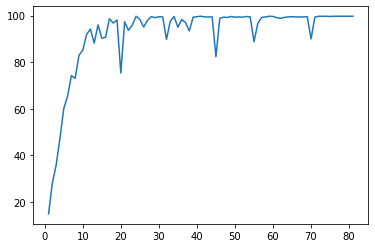

In [12]:
print("Total Run {} epoch(s)".format(Grandstore['total_epoch_run']))

plt.plot(*[range(1,Grandstore['total_epoch_run']+1)],Grandstore['acclog'])
print("Accuracy MIN: {} / MAX: {}".format(Grandstore['minacc'],Grandstore['maxacc']))
print()
print("Top {} performing epochs:".format(TOP_ACCURACY_TRACK))


gstm=Grandstore['topmodels']
for i in range(TOP_ACCURACY_TRACK):
    easy=gstm[TOP_ACCURACY_TRACK-i-1]
    print("#{} epoch {}\t||train_acc {:.2f}%\t||test {:.2f}%".format(i+1,easy[2],easy[0],easy[1]))
print()
print("Last epoch:")
lsmd=Grandstore['lastmodel']
print("epoch {}\t||train_acc {:.2f}%\t||test {:.2f}%".format(Grandstore['total_epoch_run'],lsmd[0],lsmd[1]))
      
print()
print("The model has parameters: {}".format(get_n_params(model)))
#grandstore['lastmodel']=((training_accuracy,train_epoch,thisepochtestresult))
# grandstore['lastmodel']=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)

In [13]:
  
f1=open(grandstore_string,"wb")
pickle.dump(Grandstore,f1)
f1.close()

print("writings done!")
print("Files at: "+grandstore_string)
# with open(grandstore_string, 'rb') as file:
#     myvar = pickle.load(file)
#     print(myvar)

writings done!
Files at: grandstore/tsrd_ResNet15220211023095142.pkl
